# Does your vote count? 

Yes, but only with some low probability. For the purpose of this project, let's say Carl's vote counts if Carl staying home would have changed the election outcome. In particular, Carl's vote counts if the election ends in a tie or if Carl's desired candidate wins by a single vote. Note, however, that in both cases Carl's vote only counts with probability 0.5. In the case of a tie, Carl's candidate may still lose in the tiebreaker, just as he would have if Carl hadn't voted. And in the case of a win-by-1 election, Carl's vote only counts in the cases that his candidate would have lost the tiebreaker. Thus we'd like to calculate $$0.5[P(\text{tie}) + P(\text{win by 1})].$$   

I'll focus on two-candidate winner-take-all elections here, though obviously the probability of one's vote counting should be a few times higher in a proportional representation system. 

To actually calculate the probability of an election ending so closely, we'll need to make some assumptions. For simplicity, let's assume that each potential voter is set on a candidate before the election so that we don't have to account for waffling voters. (This assumption shouldn't matter unless there something (e.g. a media gaffe) happens just before the election and systematically sways undecided voters in one direction. We'll model turnout for each candidate with the assumption that citizens decide to vote or not independently of each other. This assumption is definitely false, as people will be influenced by their social network. But again, this assumption may not matter much because in the model that follows we can set different turnout rates for each party. 

With these assumptions in place, we can model the number of votes for each candidate as a Binomial random variable with $n$ equal to the number of supporters and $p$ equal to the expected turnout rate. The probability that the first candidate wins by a single vote is $\sum_k P(\text{Candidate 1 gets k+1 votes})P(\text{Candidate 2 gets k votes})$, where $k$ ranges roughly from 0 to the lesser of the number of supporters for each candidate. If we let $s_i$ and $t_i$ be the number of supporters and turnout rate for candidate $i$, then the desired probability is 

$$\sum_k \binom{s_1}{k+1}t_1^{k+1}(1-t_1)^{s_1 - (k+1)}\binom{s_2}{k}t_2^k(1-t_2)^{s_2 - k}.$$

The formula for a tie is the same except that $k+1$ can be replaced with $k$. It's not clear to me that this can be nicely simplified without a lot of work, but it's not too hard to implement in Python: 

In [1]:
import numpy as np
from scipy.stats import binom

#Candidate 1 is the one you prefer
#Prop1/Prop2 are the proportions supporting each candidate
#The 'Result' parameter should be set to 1 for a win-by-1 scenario and 0 for a tie
def formula1(PopSize, Prop1, Prop2, Turnout1, Turnout2, Result):
    
    #Compute the necessary parameters
    Supporters1 = int(PopSize*Prop1)
    Supporters2 = int(PopSize*Prop2)
    n = int(np.minimum(Supporters1-1, Supporters2))
    terms = np.array([])
    
    if Result == 1: 
        #Compute the summation
        for k in range(n+1): 
            prob1 = binom.pmf(k+1, Supporters1, Turnout1)
            prob2 = binom.pmf(k, Supporters2, Turnout2)
            terms = np.append(terms, prob1*prob2)
        
    if Result == 0:
        #Compute the summation
        for k in range(n+1): 
            prob1 = binom.pmf(k, Supporters1, Turnout1)
            prob2 = binom.pmf(k, Supporters2, Turnout2)
            terms = np.append(terms, prob1*prob2)
    
    return np.sum(terms)

In [2]:
#Runs the previous function once for a win and once for a tie and sums the probabilities
def probability1(PopSize, Prop1, Prop2, Turnout1, Turnout2):
    win = formula1(PopSize, Prop1, Prop2, Turnout1, Turnout2, 1)
    tie = formula1(PopSize, Prop1, Prop2, Turnout1, Turnout2, 0)
    
    return 0.5*(win + tie)

probability1(10000, 0.5, 0.5, 0.5, 0.5)

0.007977848434417865

You can see that the probability of Carl's vote counting in a close race in a town of population 10,000 is a bit under 1%. 

We can also calculate the same probability using a Normal approximation to the Binomial distribution. I count the probability of $k$ votes as the area under the curve between $k-0.5$ and $k+0.5$. 

In [3]:
from scipy.stats import norm
from numpy import sqrt

def formula2(PopSize, Prop1, Prop2, Turnout1, Turnout2, Result):
    #Population parameters
    Supporters1 = int(PopSize*Prop1)
    Supporters2 = int(PopSize*Prop2)
    n = int(np.minimum(Supporters1-1, Supporters2))
    terms = np.array([])
    
    #Approximation parameters for the Normal
    mean1 = Supporters1*Turnout1
    mean2 = Supporters2*Turnout2
    stdev1 = sqrt(Supporters1*Turnout1*(1-Turnout1))
    stdev2 = sqrt(Supporters2*Turnout2*(1-Turnout2))
    
    if Result == 1: 
        for k in range(n+1): 
            #Calculate AUC
            upper1 = norm.cdf(k+1.5, mean1, stdev1)
            lower1 = norm.cdf(k+0.5, mean1, stdev1)
            upper2 = norm.cdf(k+0.5, mean2, stdev2)
            lower2 = norm.cdf(k-0.5, mean2, stdev2)
            terms = np.append(terms, (upper1 - lower1)*(upper2 - lower2))
        
    if Result == 0:
        for k in range(n+1): 
            #Calculate AUC
            upper1 = norm.cdf(k+0.5, mean1, stdev1)
            lower1 = norm.cdf(k-0.5, mean1, stdev1)
            upper2 = norm.cdf(k+0.5, mean2, stdev2)
            lower2 = norm.cdf(k-0.5, mean2, stdev2)
            terms = np.append(terms, (upper1 - lower1)*(upper2 - lower2))
    
    return np.sum(terms)

In [4]:
def probability2(PopSize, Prop1, Prop2, Turnout1, Turnout2):
    win = formula2(PopSize, Prop1, Prop2, Turnout1, Turnout2, 1)
    tie = formula2(PopSize, Prop1, Prop2, Turnout1, Turnout2, 0)
    
    return 0.5*(win + tie)

probability2(10000, 0.5, 0.5, 0.5, 0.5)

0.007977781932138642

...not bad. We get the same answer as before to 8 decimal places. 

Time for a plot: 

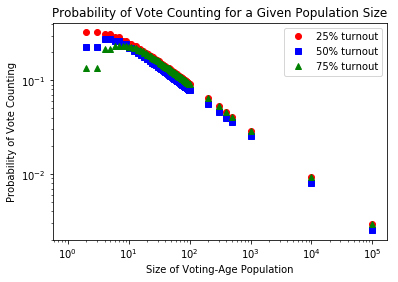

In [6]:
import matplotlib.pyplot as plt
sizes = list(range(1, 101))
sizes = sizes + [200, 300, 400, 500, 1000, 10000, 100000]
probs1 = np.array([])
probs2 = np.array([])
probs3 = np.array([])
for i in sizes:
    probs1 = np.append(probs1, probability2(i, 0.5, 0.5, 0.25, 0.25))
    probs2 = np.append(probs2, probability2(i, 0.5, 0.5, 0.5, 0.5))
    probs3 = np.append(probs3, probability2(i, 0.5, 0.5, 0.75, 0.75))

plt.xscale('log')
plt.yscale('log')
plt.plot(sizes, probs1, 'ro', sizes, probs2, 'bs', sizes, probs3, 'g^')
plt.ylabel('Probability of Vote Counting')
plt.xlabel('Size of Voting-Age Population')
plt.title('Probability of Vote Counting for a Given Population Size')
plt.legend(('25% turnout', '50% turnout', '75% turnout'), loc = 'upper right')
plt.show();

The probability of such a close race is more sizeable than I'd have predicted. Presumably the reason we don't see more results like this in reality is that it's rare for the supporting populations to be so equally sized (here they're set to be exactly equal). 